In [1]:
import os
import umap
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from mpl_toolkits.axes_grid1 import ImageGrid

from utils.CV import HogExtractor
from utils.model_maybe import maybe_fit, maybe_predict
from utils.CIFAR10 import CIFAR10Loader, CIFAR10Downloader, CIFAR10Sequence

C:\Users\simplifyall\Anaconda3\envs\tensorflow3.6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Paths setup

In [2]:
DATA_PATH = "data"
DATA_DIR = "cifar-10-batches-py"
MODELS_PATH = "models"

## Download and extract

In [3]:
cifar10_downloader = CIFAR10Downloader(DATA_PATH)
cifar10_downloader.maybe_download()

## Load

In [4]:
cifar10_loader = CIFAR10Loader(os.path.join(DATA_PATH, DATA_DIR))
X_train, y_train = cifar10_loader.load_training_data()
X_test, y_test = cifar10_loader.load_test_data()
labels_dict = cifar10_loader.load_metadata()

## Print randomized grid

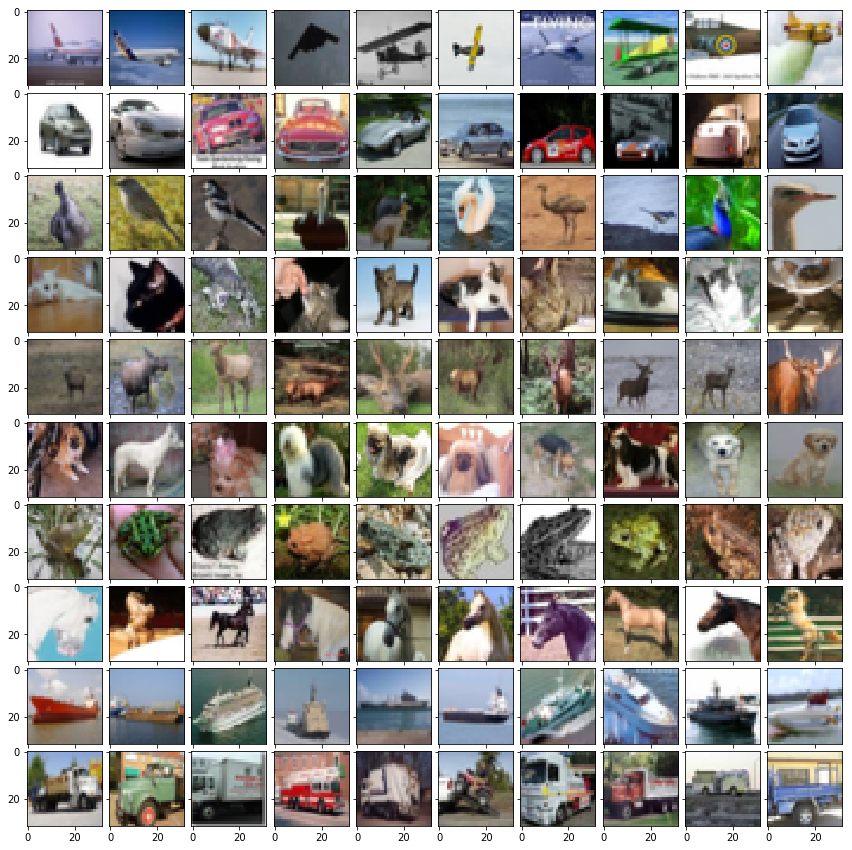

In [5]:
rows = columns = 10
fig = plt.figure(1, (15., 15.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(rows, columns),
                 axes_pad=0.1
                 )


for i in range(rows):
    to_print = X_train[y_train == i]
    rand_index = np.random.choice(to_print.shape[0], columns, replace=False)
    for j, index in enumerate(rand_index):
        grid[i*rows+j].imshow(to_print[index])
        
plt.show()

## Shallow classifier

In [6]:
descriptor = HogExtractor()
clf = LinearSVC()

In [7]:
X_train_hog = descriptor.transform(X_train)
X_test_hog = descriptor.transform(X_test)

Firstly, **SVC** (*libsvm* implementation) with linear kernel was used, but the training and predicting was taking an enormous amount of time. Due to that **LinearSVC** (*linearlib* implementation) was used here and along whole exercise.

In [8]:
model_dump = 'linsvc_model.sav'
result_dump = 'linsvc_predicted.npy'

clf = maybe_fit(clf, X_train_hog, y_train, os.path.join(MODELS_PATH, model_dump))
result = maybe_predict(clf, X_test_hog, result_dump)
accuracy_score(y_test, result)

0.1

The result is definitely not satisfying.

## CNN codes

In [9]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Input

In [10]:
_BATCH_SIZE = 100
_MIN_INCV3_SIZE = 139
_NUM_CHANELS = 3

In [11]:
def create_model(input_shape=(_MIN_INCV3_SIZE, _MIN_INCV3_SIZE, _NUM_CHANELS), top=True):
    input_tensor = Input(shape=input_shape)
    inc_v3 = InceptionV3(input_tensor=input_tensor, include_top=top)
    return Model(inputs=(inc_v3.input), outputs=(inc_v3.layers[-1].input))

Extracting CNN codes were quite fast even on my mobile *NVIDIA GTX860M*. Sequence generator was defined because the images were too small to feed the network (*InceptionV3* requires minimum input to be at least 139x139) They are resized in batches during learning so there's no need of keeping additional data in memory. Batch size was picked to avoid running out of GPU memory.

In [12]:
incv3_train_file = os.path.join(MODELS_PATH, 'incv3_train_top.sav')
incv3_test_file = os.path.join(MODELS_PATH, 'incv3_test_top.sav')

meta = {"train":{"in": X_train,
                 "dump": incv3_train_file}, 
        "test":{"in": X_test,
                 "dump": incv3_test_file}
       }

if not os.path.exists(incv3_train_file) or not os.path.exists(incv3_test_file):
    model = create_model()
    for data_name, data in meta.items():
        print(f"{data_name} features extraction")
        generator = CIFAR10Sequence(batch_size=_BATCH_SIZE, target_size=_MIN_INCV3_SIZE, x_set=data["in"])
        data["out"] = model.predict_generator(generator)
        joblib.dump(data["out"], data["dump"])
        

X_train_incv3 = joblib.load(meta["train"]["dump"])
X_test_incv3 = joblib.load(meta["test"]["dump"])

## Visualization

In [13]:
dims = X_train_incv3.shape[1]
pca = PCA(n_components=dims).fit(X_train_incv3)

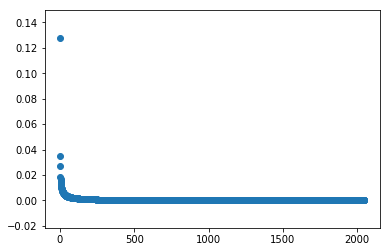

In [14]:
plt.scatter(list(range(dims)), pca.explained_variance_ratio_)

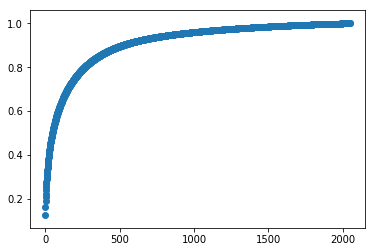

In [15]:
plt.scatter(list(range(dims)), pca.explained_variance_ratio_.cumsum())

In [16]:
dims = (100*x for x in range(1,6))
for dim in dims:
    print(pca.explained_variance_ratio_.cumsum()[dim])

0.6264941
0.75191563
0.8217008
0.86580676
0.8954606


I've decided to combine PCA with UMAP as it is a proven technique for me. 500 dimensional PCA looks promising as it holds nearly 90% of whole variance.

In [17]:
pca = PCA(n_components=500).fit_transform(X_train_incv3)

In [18]:
umap_res = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(pca)

In [19]:
umap_frame = pd.DataFrame(umap_res, columns=['umap%i' % i for i in range(2)])
umap_frame["labels"] = y_train

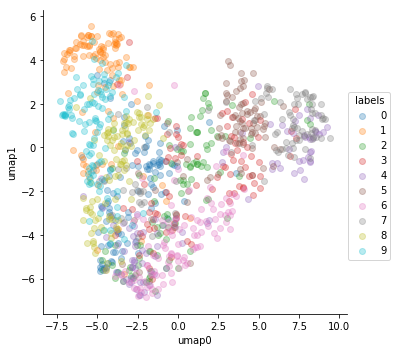

In [20]:
sns.lmplot(data=umap_frame.iloc[:1000,:], x="umap0", y="umap1", hue="labels", fit_reg=False, scatter_kws={'alpha':0.3})

We can see here that classes are not easily separable. Let's take a look at more plots.

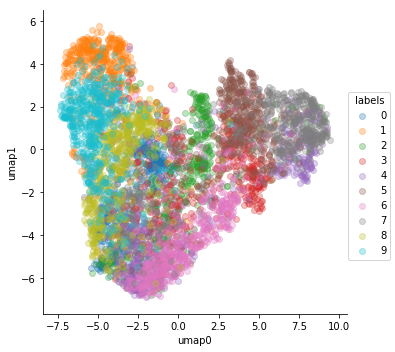

In [21]:
sns.lmplot(data=umap_frame.iloc[:5000,:], x="umap0", y="umap1", hue="labels", fit_reg=False, scatter_kws={'alpha':0.3})

In [22]:
pca_plot = pd.DataFrame(PCA(n_components=2).fit_transform(X_train_incv3), columns=['pca%i' % i for i in range(2)])
pca_plot["labels"] = y_train

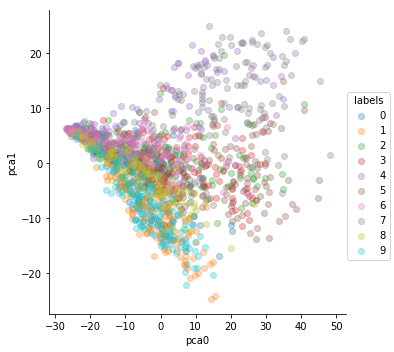

In [23]:
sns.lmplot(data=pca_plot.iloc[:1500,:], x="pca0", y="pca1", hue="labels", fit_reg=False, scatter_kws={'alpha':0.3})

In [24]:
umap_res_full = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_train_incv3)

In [25]:
umap_full_frame = pd.DataFrame(umap_res_full, columns=['umap%i' % i for i in range(2)])
umap_full_frame["labels"] = y_train

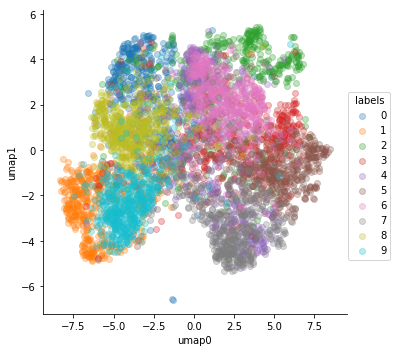

In [26]:
sns.lmplot(data=umap_full_frame.iloc[:5000,:], x="umap0", y="umap1", hue="labels", fit_reg=False, scatter_kws={'alpha':0.3})

## LinearSVM

In [27]:
loss = "squared_hinge"
penalty = "l2"
dual = False
C = 0.58*1e-3
class_weight = "balanced"
fit_intercept = False
intercept_scaling = 1

In [28]:
clf_linear = LinearSVC(loss=loss, penalty=penalty, dual=dual, C=C, fit_intercept=fit_intercept,
                      intercept_scaling=intercept_scaling, class_weight=class_weight)
model_dump = f'linear_top_{loss}_{penalty}_{dual}_{C}_{class_weight}_{fit_intercept}_{intercept_scaling}_incv3_model.sav'
clf_linear = maybe_fit(clf_linear, X_train_incv3, y_train, os.path.join(MODELS_PATH, model_dump))
result = clf_linear.predict(X_test_incv3)

In [29]:
accuracy_score(y_test, result)

0.8078

In [30]:
umap_test_full = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_test_incv3)
umap_test_frame = pd.DataFrame(umap_test_full, columns=['umap%i' % i for i in range(2)])

umap_test_frame["predict"] = result
umap_test_frame["labels"] = y_test

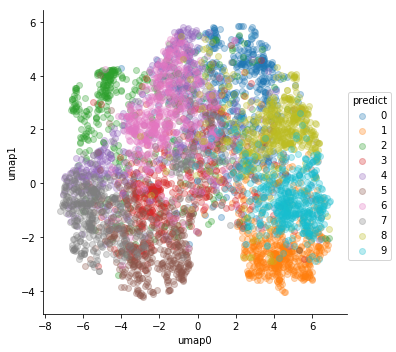

In [31]:
sns.lmplot(data=umap_test_frame.iloc[:5000,:], x="umap0", y="umap1", hue="predict", fit_reg=False, scatter_kws={'alpha':0.3})

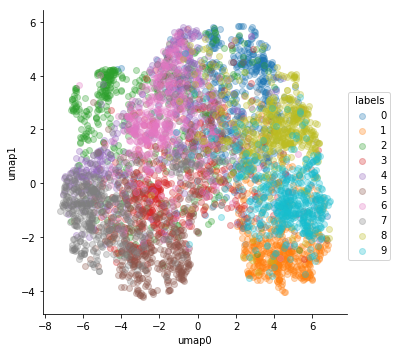

In [32]:
sns.lmplot(data=umap_test_frame.iloc[:5000,:], x="umap0", y="umap1", hue="labels", fit_reg=False, scatter_kws={'alpha':0.3})

In [33]:
umap_test_frame["diff"] = y_test == result

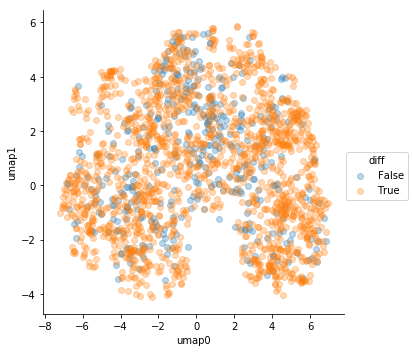

In [34]:
sns.lmplot(data=umap_test_frame.iloc[:2000,:], x="umap0", y="umap1", hue="diff", fit_reg=False, scatter_kws={'alpha':0.3})

Unfortunately, a was not able to obtain circa 87% accuracy. Maybee using **SVC** score would be better as there are more tunable parameters but it will take me ages to train and predict all these models. So 80.78% in a finite amount of time is better than 87% someday.